# Imports and configs

In [1]:
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from scipy.special import logit
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e10/train.csv'
    test_path = '/kaggle/input/playground-series-s4e10/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'
    original_data_path = '/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv'
    
    target = 'loan_status'
    n_folds = 5
    seed = 1859

# Data loading and preprocessing

In [3]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

train.shape, test.shape

((58645, 12), (39098, 11))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [6]:
train.loan_status.value_counts(normalize=True)

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

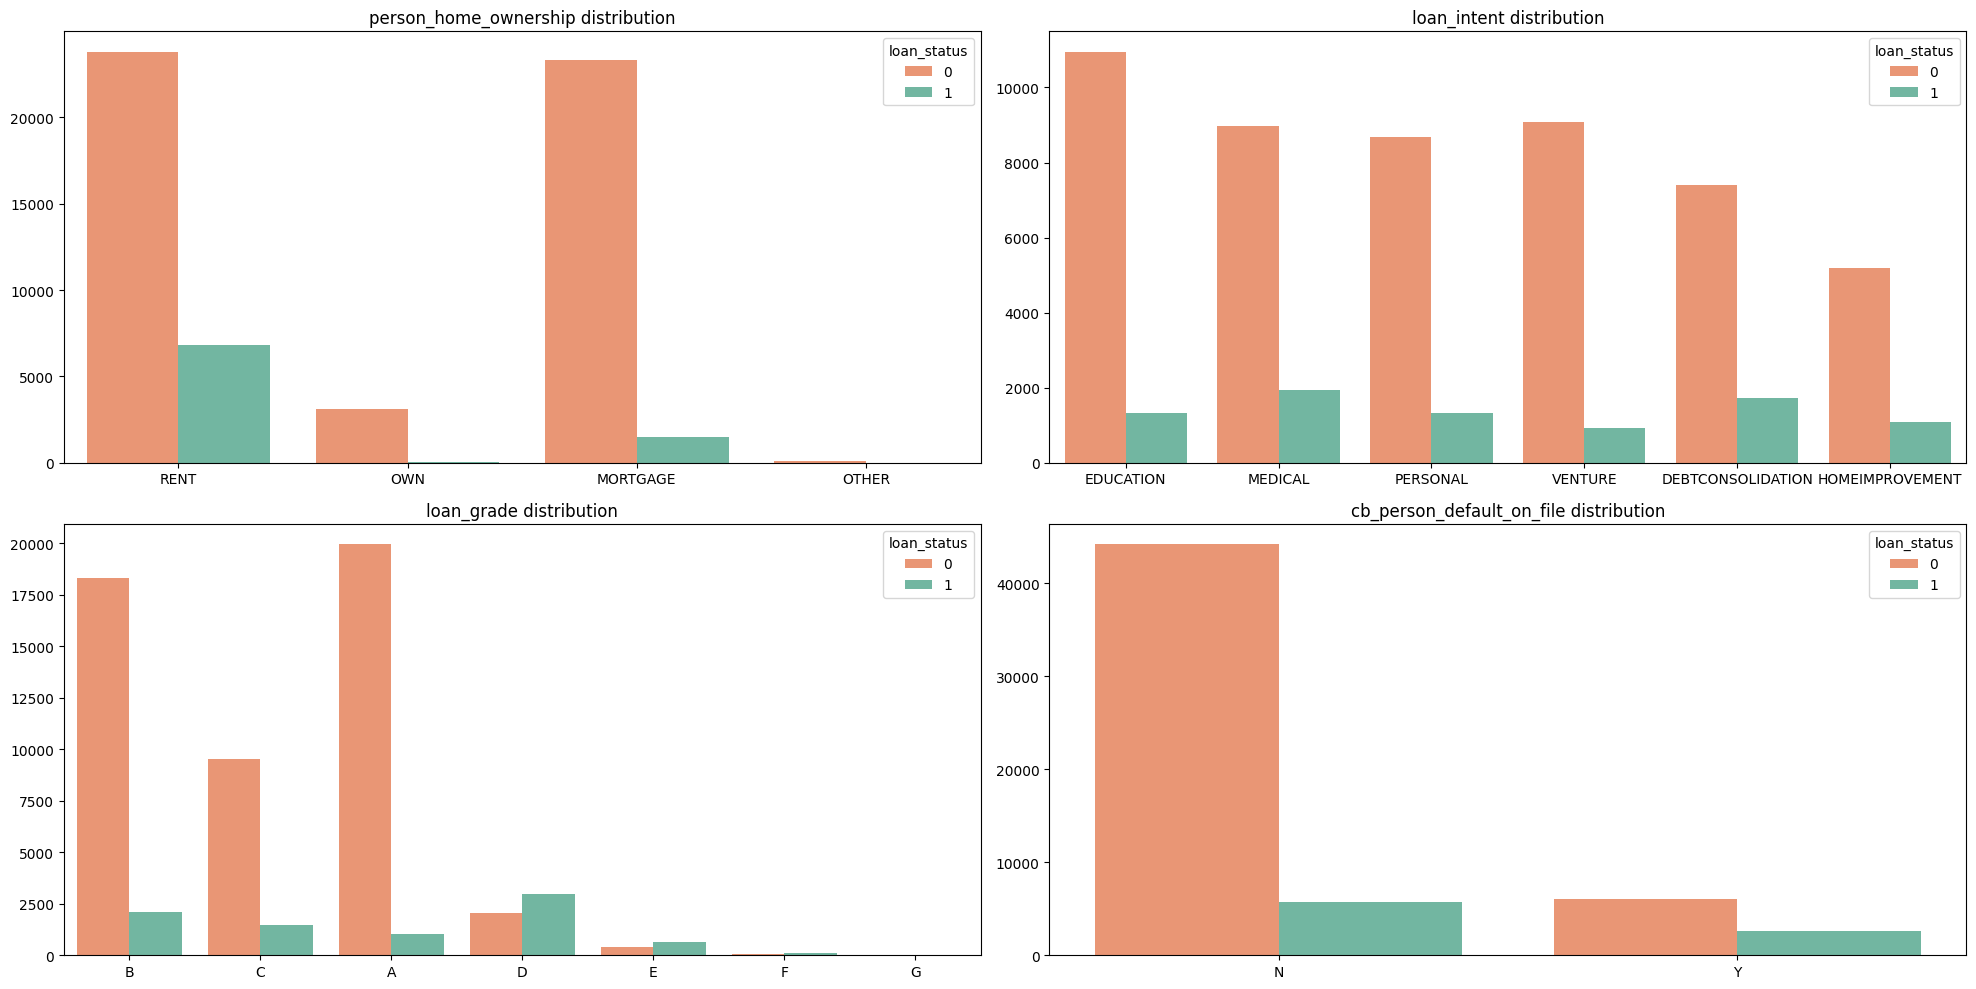

In [7]:
cat_cols = train.select_dtypes(include='object').columns.tolist()

palette = {0: sns.color_palette("Set2")[1], 1: sns.color_palette("Set2")[0]}
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(data=train, x=col, hue=CFG.target, ax=axes[i], palette=palette)
    axes[i].set_title(f'{col} distribution')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

**Observations**:
- The dataset is relatively small compared to those we've seen in recent months in the playground series. It is also imbalanced, with the minority class representing less than 15%.
- It contains 4 categorical features, all of which have low cardinality. The remaining features are numerical.
- There are no missing values.

Most of the models I plan to use can by default handle categorical features. However, `HistGradientBoostingClassifier` only accepts numerical features. For this model, I will encode the categorical features using `OrdinalEncoder`.

Below, I have created a small function that converts the data types of categorical features to the `category` type and encodes them into numerical values if necessary. The same preprocessing steps are also applied to the original dataset. Note that the original dataset will only be used for training, for validation during training only the competition data is used.

In [8]:
def get_data(encode=False, impute=False, for_catboost=False):
    train = pd.read_csv(CFG.train_path, index_col='id')
    test = pd.read_csv(CFG.test_path, index_col='id')
    original = pd.read_csv(CFG.original_data_path)
    
    if impute:
        original['person_emp_length'] = original['person_emp_length'].fillna(original['person_emp_length'].median())
        original['loan_int_rate'] = original['loan_int_rate'].fillna(original['loan_int_rate'].mean())
    
    if for_catboost:
        cat_cols = test.columns.tolist()
    else:
        cat_cols = test.select_dtypes(include='object').columns.tolist()
        
    train[cat_cols] = train[cat_cols].astype(str).astype('category')
    test[cat_cols] = test[cat_cols].astype(str).astype('category')
    original[cat_cols] = original[cat_cols].astype(str).astype('category')
    
    if encode:
        encoder = OrdinalEncoder()
        train[cat_cols] = encoder.fit_transform(train[cat_cols])
        test[cat_cols] = encoder.transform(test[cat_cols])
        original[cat_cols] = encoder.transform(original[cat_cols])
        
    X = train.drop(CFG.target, axis=1)
    y = train[CFG.target]
    X_test = test
    
    X_original = original.drop(CFG.target, axis=1)
    y_original = original[CFG.target]
    
    return X, y, X_test, X_original, y_original

Both correlation and mutual information show that there is little signal in `person_age` and `cb_person_cred_hist_length`. However, I'll leave both of them in the dataset since there is some signal in them.

In [9]:
X_mi, y_mi, _, _, _ = get_data(encode=True)

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_mi.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
person_income,0.096686
loan_int_rate,0.082537
loan_grade,0.079448
loan_percent_income,0.078911
person_home_ownership,0.038536
cb_person_default_on_file,0.016186
loan_amnt,0.015289
loan_intent,0.009571
person_emp_length,0.008952
cb_person_cred_hist_length,0.000930


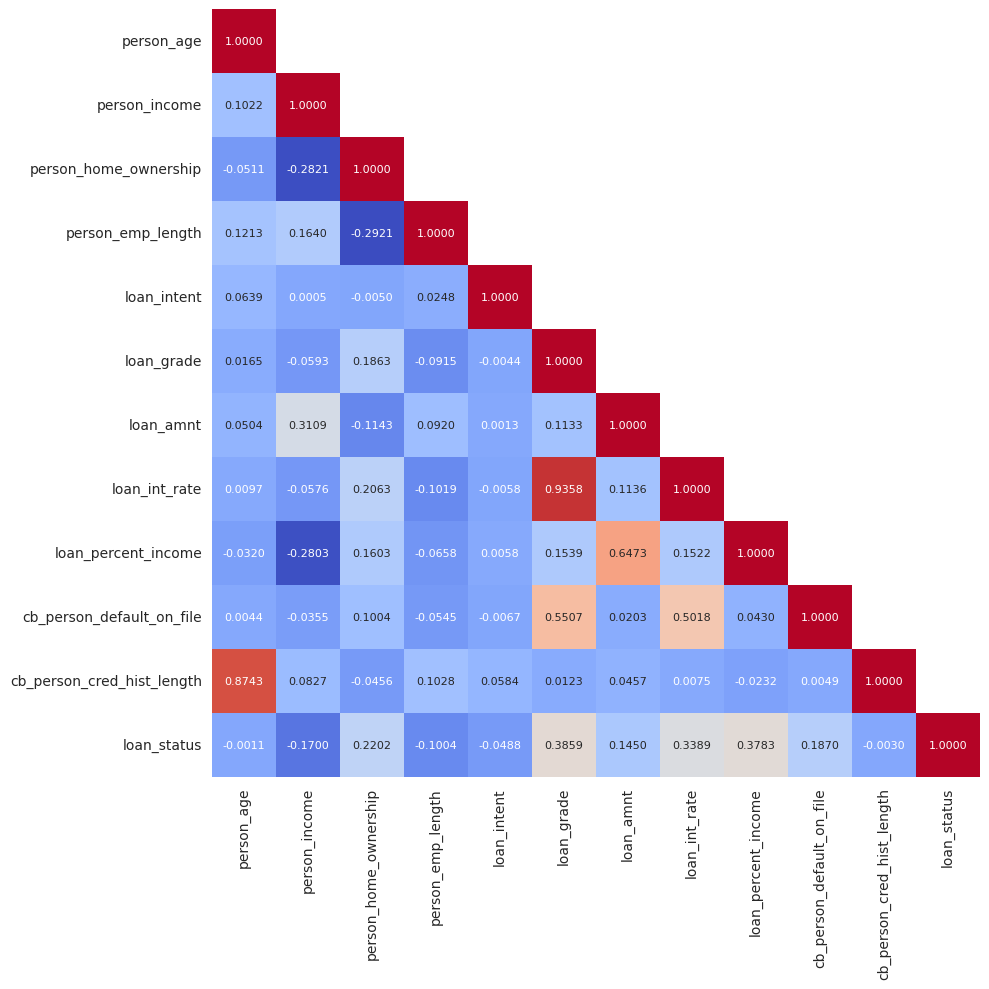

In [10]:
sns.set_style("white")
plt.figure(figsize=(10, 10))

corr_train = pd.concat([X_mi, y_mi], axis=1).corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.4f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 8},
    cbar=False
)

plt.tight_layout()
plt.show()

# Training base models

To simplify the process of training, cross-validation, and inference, etc. I will create a class that handles all the necessary logic. This class will do cross-validation using `StratifiedKFold`, train the models, save their out-of-fold predictions, and create a submission file for the final ensemble model.

In [11]:
class Trainer:
    def __init__(self, model, config=CFG, is_ensemble_model=False):
        self.model = model
        self.config = config
        self.is_ensemble_model = is_ensemble_model

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            if not self.is_ensemble_model:
                X_train = pd.concat([X_train, X_original], ignore_index=True)
                y_train = pd.concat([y_train, y_original], ignore_index=True)
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble_model:
                coeffs += model.coef_ / self.config.n_folds
                n_iters = model.n_iter_[0]
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if self.is_ensemble_model:
                print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f} ({n_iters} iterations)')
            else:
                print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f}')
            
        overall_score = roc_auc_score(y, oof_pred_probs[:, 1])
            
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        
        if self.is_ensemble_model:
            self._save_submission(test_pred_probs, np.mean(scores))
            return scores, coeffs
        else:
            os.makedirs('oof_pred_probs', exist_ok=True)
            os.makedirs('test_pred_probs', exist_ok=True)
            self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
            self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
            return oof_pred_probs[:, 1], test_pred_probs[:, 1], scores
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{name}_pred_probs/{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_pred_probs, score):
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub = pd.read_csv(self.config.sample_sub_path)
        sub[self.config.target] = test_pred_probs[:, 1]
        sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)

In [12]:
hgb_params = {
    'l2_regularization': 18.936024747438683,
    'learning_rate': 0.09659889512539407,
    'max_depth': 282,
    'max_iter': 782,
    'max_leaf_nodes': 17,
    'min_samples_leaf': 27,
    'random_state': 1859
}

gb_params = {
    'learning_rate': 0.082157083069963,
    'max_depth': 42,
    'max_features': 0.830492388655695,
    'max_leaf_nodes': 396,
    'min_samples_leaf': 0.004149017494612162,
    'min_samples_split': 0.3832043623592848,
    'min_weight_fraction_leaf': 0.03369793416121497,
    'n_estimators': 1910,
    'random_state': 1859,
    'subsample': 1
}

xgb_params = {
    'colsample_bylevel': 0.891682515878179,
    'colsample_bynode': 0.9692022033782264,
    'colsample_bytree': 0.5741212531177258,
    'enable_categorical': True,
    'gamma': 3.3732530314473403,
    'max_depth': 28,
    'max_leaves': 5,
    'min_child_weight': 11.394380268039894,
    'n_estimators': 1494,
    'n_jobs': -1,
    'random_state': 1859,
    'reg_alpha': 3.9898421425365447,
    'reg_lambda': 5.872485568309149,
    'scale_pos_weight': 6.3669510043139965,
    'subsample': 0.9291585219816468,
    'verbosity': 0
}

lgbm_params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.4102117160463167,
    'learning_rate': 0.018429467144621937,
    'min_child_samples': 152,
    'min_child_weight': 0.3352178855961433,
    'n_estimators': 1830,
    'n_jobs': -1,
    'num_leaves': 24,
    'random_state': 1859,
    'reg_alpha': 4.467573158371641,
    'reg_lambda': 7.274798299326913,
    'scale_pos_weight': 9.782647775062838,
    'subsample': 0.5849708880697966,
    'verbose': -1
}

lgbm_dart_params = {
    'boosting_type': 'dart',
    'colsample_bytree': 0.4342375371792583,
    'learning_rate': 0.09198605888855686,
    'min_child_samples': 50,
    'min_child_weight': 0.8796787910068157,
    'n_estimators': 997,
    'n_jobs': -1,
    'num_leaves': 30,
    'random_state': 1859,
    'reg_alpha': 4.256638460413229,
    'reg_lambda': 1.002971761999517,
    'scale_pos_weight': 6.623252385677123,
    'subsample': 0.7401348503074506,
    'verbose': -1
}

cb_params = {
    'border_count': 32,
    'colsample_bylevel': 0.923205561025516,
    'depth': 6,
    'iterations': 1183,
    'l2_leaf_reg': 5.364502503541399,
    'learning_rate': 0.0384421792065224,
    'min_child_samples': 171,
    'random_state': 1859,
    'random_strength': 0.7074622236783702,
    'scale_pos_weight': 3.429086606834293,
    'subsample': 0.30083640912523346,
    'verbose': False
}

In [13]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [14]:
X, y, X_test, X_original, y_original = get_data(encode=True, impute=True)
hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_trainer = Trainer(hgb_model)
oof_pred_probs['HistGB'], test_pred_probs['HistGB'], scores['HistGB'] = hgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training HistGradientBoostingClassifier

--- Fold 1 - AUC: 0.960437
--- Fold 2 - AUC: 0.956519
--- Fold 3 - AUC: 0.957955
--- Fold 4 - AUC: 0.952592
--- Fold 5 - AUC: 0.956001

------ Overall: 0.956704 | Average: 0.956701 ± 0.002567


In [15]:
X, y, X_test, X_original, y_original = get_data(encode=True, impute=True)
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
oof_pred_probs['GradientBoosting'], test_pred_probs['GradientBoosting'], scores['GradientBoosting'] = gb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training GradientBoostingClassifier

--- Fold 1 - AUC: 0.961971
--- Fold 2 - AUC: 0.958085
--- Fold 3 - AUC: 0.959971
--- Fold 4 - AUC: 0.955871
--- Fold 5 - AUC: 0.959571

------ Overall: 0.959098 | Average: 0.959094 ± 0.002034


In [16]:
X, y, X_test, X_original, y_original = get_data(encode=False, impute=False)
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_pred_probs['XGBoost'], test_pred_probs['XGBoost'], scores['XGBoost'] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training XGBClassifier

--- Fold 1 - AUC: 0.962199
--- Fold 2 - AUC: 0.960245
--- Fold 3 - AUC: 0.961378
--- Fold 4 - AUC: 0.954572
--- Fold 5 - AUC: 0.959501

------ Overall: 0.959570 | Average: 0.959579 ± 0.002669


In [17]:
X, y, X_test, X_original, y_original = get_data(encode=False, impute=False)
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_pred_probs['LightGBM'], test_pred_probs['LightGBM'], scores['LightGBM'] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - AUC: 0.965308
--- Fold 2 - AUC: 0.962808
--- Fold 3 - AUC: 0.962960
--- Fold 4 - AUC: 0.958873
--- Fold 5 - AUC: 0.962159

------ Overall: 0.962397 | Average: 0.962422 ± 0.002070


In [18]:
X, y, X_test, X_original, y_original = get_data(encode=False, impute=False)
lgbm_dart_model = LGBMClassifier(**lgbm_dart_params)
lgbm_dart_trainer = Trainer(lgbm_dart_model)
oof_pred_probs['LightGBM (dart)'], test_pred_probs['LightGBM (dart)'], scores['LightGBM (dart)'] = lgbm_dart_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

--- Fold 1 - AUC: 0.965052
--- Fold 2 - AUC: 0.963055
--- Fold 3 - AUC: 0.961995
--- Fold 4 - AUC: 0.958556
--- Fold 5 - AUC: 0.961690

------ Overall: 0.962055 | Average: 0.962070 ± 0.002115


In [19]:
X, y, X_test, X_original, y_original = get_data(encode=False, impute=True, for_catboost=True)
cb_model = CatBoostClassifier(**cb_params, cat_features=X.columns.tolist())
cb_trainer = Trainer(cb_model)
oof_pred_probs['CatBoost'], test_pred_probs['CatBoost'], scores['CatBoost'] = cb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training CatBoostClassifier

--- Fold 1 - AUC: 0.969033
--- Fold 2 - AUC: 0.967882
--- Fold 3 - AUC: 0.971089
--- Fold 4 - AUC: 0.962764
--- Fold 5 - AUC: 0.970321

------ Overall: 0.968170 | Average: 0.968218 ± 0.002939


I will also add OOF files from an AutoGluon run that I trained in [another notebook](https://www.kaggle.com/code/ravaghi/s04e10-loan-approval-prediction-autogluon).

In [20]:
def get_autogluon_data():
    base_path = '/kaggle/input/s04e10-loan-approval-prediction-autogluon/'
    oof_pred_probs = pickle.load(open(base_path + 'autogluon_oof_pred_probs_0.960551.pkl', 'rb'))
    test_pred_probs = pickle.load(open(base_path + 'autogluon_test_pred_probs_0.960551.pkl', 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]          
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        scores.append(score)
        
    return oof_pred_probs[:, 1], test_pred_probs[:, 1], scores

In [21]:
oof_pred_probs['AutoGluon'], test_pred_probs['AutoGluon'], scores['AutoGluon'] = get_autogluon_data()

# Ensembling with Logistic Regression

I will use `LogisticRegression` to ensemble the predictions of the base models. The predictions are converted to logits and fed into the logistic regression model as features.

In [22]:
X = np.column_stack(list(oof_pred_probs.values()))
X_test = np.column_stack(list(test_pred_probs.values()))

X = pd.DataFrame(logit(X))
X_test = pd.DataFrame(logit(X_test))

lr_model = LogisticRegression(random_state=CFG.seed, max_iter=500, C=0.007)
lr_trainer = Trainer(lr_model, is_ensemble_model=True)
scores['Ensemble'], coeffs = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - AUC: 0.969964 (37 iterations)
--- Fold 2 - AUC: 0.968488 (37 iterations)
--- Fold 3 - AUC: 0.971184 (36 iterations)
--- Fold 4 - AUC: 0.963880 (39 iterations)
--- Fold 5 - AUC: 0.970185 (40 iterations)

------ Overall: 0.968676 | Average: 0.968740 ± 0.002578


Here, we can see the coefficients of the logistic regression model, which represent the contribution of each base model's prediction to the final ensemble output. A positive coefficient indicates that the corresponding base model's predictions positively influence the final prediction, and a negative coefficient suggests a negative impact.

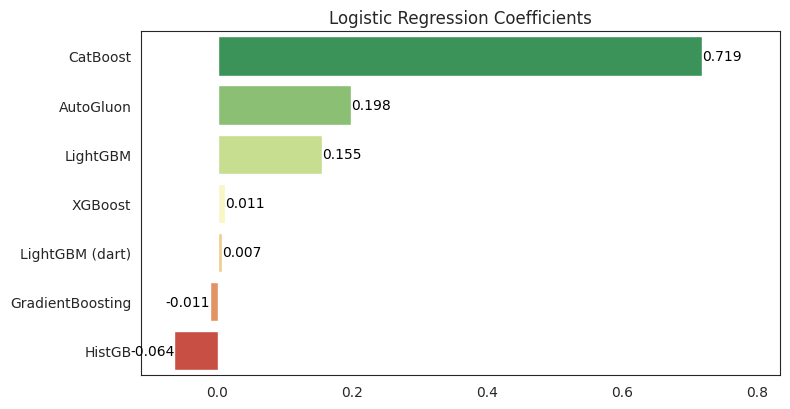

In [23]:
sorted_indices = np.argsort(coeffs[0])[::-1]
sorted_coeffs = np.array(coeffs[0])[sorted_indices]
sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

plt.figure(figsize=(8, coeffs.shape[1] * 0.6))
ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
    if value > 0:
        ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
    else:
        ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

xlim = ax.get_xlim()
ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))
        
plt.title('Logistic Regression Coefficients')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Results

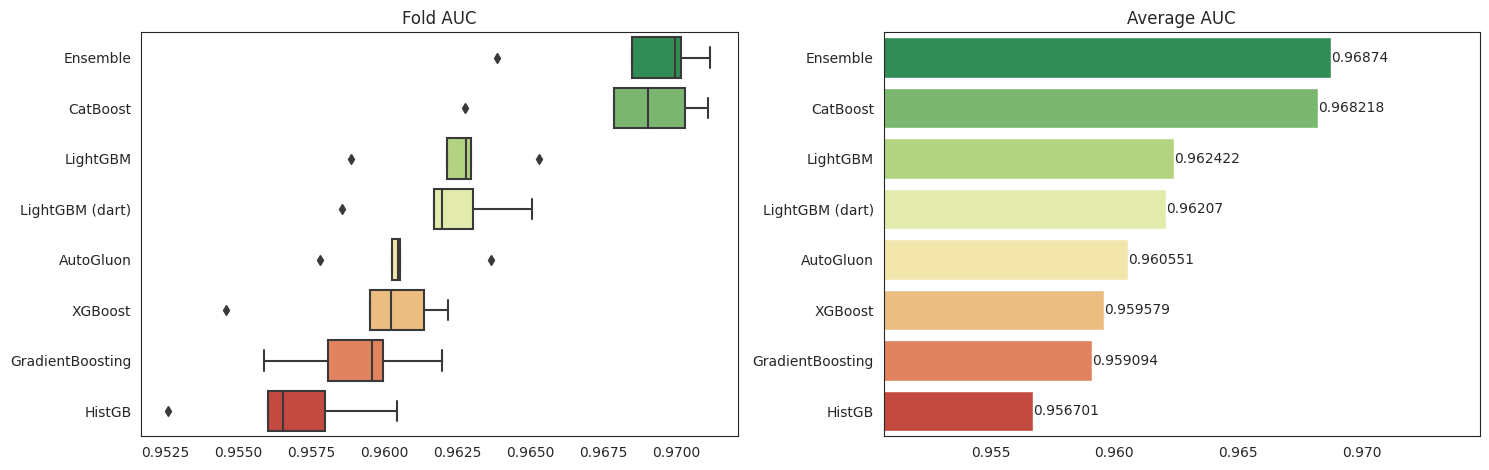

In [24]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.6))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

In [25]:
shutil.rmtree('catboost_info', ignore_errors=True)